In [1]:
# Cell 1
import gc
import numpy as np
import pandas as pd

import lightgbm as lgb

/home/coder/ICTProject/.venv/lib/python3.11/site-packages/distributed/diagnostics/rmm.py:8: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
  import rmm
/home/coder/ICTProject/.venv/lib/python3.11/site-packages/rmm/__init__.py:15: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
  from rmm import mr


In [2]:
# Cell 2 – load prepared ranking data (lean, no NumPy copies)
import json, os, numpy as np, pandas as pd, gc

META_PATH = '../data/outputs/dataset_meta.json'
TRAIN_RANK_PATH = '../data/outputs/train_rank.parquet'
VALID_RANK_PATH = '../data/outputs/valid_rank.parquet'
GROUP_TRAIN_PATH = '../data/outputs/groups_train.npy'
GROUP_VALID_PATH = '../data/outputs/groups_valid.npy'

with open(META_PATH) as f:
    meta = json.load(f)

# Use intersected feature list written by prepare script
feature_cols = meta['model_features']

train_df = pd.read_parquet(TRAIN_RANK_PATH)
valid_df = pd.read_parquet(VALID_RANK_PATH)

# Safety: enforce intersection (avoids KeyError if meta stale)
available = set(train_df.columns)
feature_cols = [c for c in feature_cols if c in available]

train_group = np.load(GROUP_TRAIN_PATH)
valid_group = np.load(GROUP_VALID_PATH)

print("Train rows:", len(train_df), "Valid rows:", len(valid_df))
print("Features used:", len(feature_cols))
print("Groups train:", len(train_group), "valid:", len(valid_group))
# ~ 35gb of ram usage, 22s

Train rows: 210021247 Valid rows: 52394815
Features used: 26
Groups train: 1097848 valid: 274132


In [3]:
# Cell 3 – user activity stats (match old behavior: use full data = train + valid)
tmp = pd.concat(
    [
        train_df[['customer_id', 'cust_purchases_4w', 'customer_total_purchases']],
        valid_df[['customer_id', 'cust_purchases_4w', 'customer_total_purchases']],
    ],
    ignore_index=True
).drop_duplicates('customer_id')

print("Users with any history:", (tmp['customer_total_purchases'] > 0).sum())
print("Users with 0 history but some recent:",
      ((tmp['customer_total_purchases'] == 0) & (tmp['cust_purchases_4w'] > 0)).sum())
print("Users with history but no recent activity:",
      ((tmp['customer_total_purchases'] > 0) & (tmp['cust_purchases_4w'] == 0)).sum())
del tmp
gc.collect()

# ~ 22gb of ram usage, 2s

Users with any history: 1356709
Users with 0 history but some recent: 0
Users with history but no recent activity: 1121432


22

In [4]:
# Cell 4 – train ranker (use pandas directly; no extra arrays)
ranker_params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'n_estimators': 200,
}
ranker = lgb.LGBMRanker(**ranker_params, verbose=10, n_jobs=-1)
eval_results_ranker = {}
ranker.fit(
    train_df[feature_cols], train_df['label'],
    group=train_group,
    eval_set=[(valid_df[feature_cols], valid_df['label'])],
    eval_group=[valid_group],
    eval_at=[12],
    callbacks=[
        lgb.record_evaluation(eval_results_ranker),
        lgb.early_stopping(stopping_rounds=20, verbose=False),
    ],
)
del train_df, valid_df, train_group, valid_group
gc.collect()

# ~ 59gb of ram usage, 13 min 5s

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.861840
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.171064
[LightGBM] [Debug] init for col-wise cost 12.522468 seconds, init for row-wise cost 10.587674 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 15.505394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Usi

259

In [5]:
# Scoring
FEATURE_PATH = '../data/outputs/features.parquet'
if 'data' not in locals() or data is None:
    data = pd.read_parquet(FEATURE_PATH, columns=feature_cols + ['customer_id','article_id'])

BATCH_SIZE = 20_000_000
n_rows = len(data)
scores = np.empty(n_rows, dtype=np.float32)

assert len(feature_cols) == ranker.n_features_in_, f"Model expects {ranker.n_features_in_}, feature_cols has {len(feature_cols)}"
for start in range(0, n_rows, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_rows)
    X_batch = data.iloc[start:end][feature_cols].to_numpy(dtype='float32')
    scores[start:end] = ranker.predict(X_batch).astype(np.float32)
    del X_batch
    gc.collect()

all_data_rank = data[['customer_id','article_id']].copy()
all_data_rank['score'] = scores
del scores, data
gc.collect()

# ~ 23gb of ram usage, 3 min 2s

/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


0

In [6]:
# Print cell (rename from all_data_clf)
print("all_data_rank rows:", len(all_data_rank))
print("all_data_rank customers:", all_data_rank['customer_id'].nunique())

all_data_rank rows: 262416062
all_data_rank customers: 1371980


value                     474
customer_unique_articles  379
customer_mean_price       373
article_mean_price        361
article_total_purchases   338
days_since_last_purchase  316
customer_days_since_last_purchase 275
window_type_code          271
article_unique_customers  255
age                       227
product_type_no           175
customer_total_purchases  170
cust_purchases_1w         168
garment_group_no          160
section_no                157
colour_group_code         149
cust_purchases_4w         147
postal_code               122
graphical_appearance_no   91
product_group_name        68
perceived_colour_master_id 62
index_code                53
perceived_colour_value_id 46
fashion_news_frequency    6
index_group_no            6
club_member_status        2


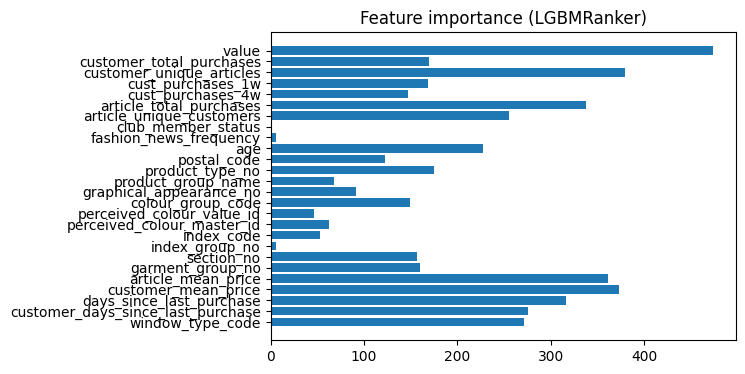

In [ ]:
# cell 9
import matplotlib.pyplot as plt

importances = ranker.feature_importances_
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{name:25s} {imp}")

plt.figure(figsize=(8, 6))
plt.barh(feature_cols, importances)
plt.gca().invert_yaxis()
plt.title("Feature importance (LGBMRanker)")
plt.show()

In [8]:
# cell 10
gc.collect()

5989

In [9]:
# Cell 11 – build predictions per integer customer_id (no hex mapping here)
# Requires: all_data_rank with columns [customer_id, article_id, score] already in memory.

all_data_rank['article_id_str'] = '0' + all_data_rank['article_id'].astype(str)

BATCH_CUSTOMERS = 1_000_000
unique_cust = all_data_rank['customer_id'].unique()
pred_parts = []

for start in range(0, len(unique_cust), BATCH_CUSTOMERS):
    end = min(start + BATCH_CUSTOMERS, len(unique_cust))
    cust_chunk = unique_cust[start:end]
    chunk = all_data_rank[all_data_rank['customer_id'].isin(cust_chunk)].copy()
    chunk = chunk.sort_values(['customer_id', 'score'], ascending=[True, False])
    chunk = chunk.groupby('customer_id', group_keys=False).head(12)
    part = (
        chunk.groupby('customer_id')['article_id_str']
             .apply(lambda x: ' '.join(x))
             .reset_index()
             .rename(columns={'customer_id': 'customer_id_int',
                              'article_id_str': 'prediction'})
    )
    pred_parts.append(part)
    del chunk, part
    gc.collect()

pred_df_rank_int = pd.concat(pred_parts, ignore_index=True)
del pred_parts
gc.collect()

print("pred_df_rank_int rows:", len(pred_df_rank_int))
print("pred_df_rank_int customers:", pred_df_rank_int['customer_id_int'].nunique())

pred_df_rank_int['n_items'] = pred_df_rank_int['prediction'].str.split().str.len()
print("Mean items per predicted customer:", pred_df_rank_int['n_items'].mean())
print("Min items per predicted customer:", pred_df_rank_int['n_items'].min())
print("Max items per predicted customer:", pred_df_rank_int['n_items'].max())
print("Total customer–item pairs:", pred_df_rank_int['n_items'].sum())
pred_df_rank_int.head()

del all_data_rank
gc.collect()
# ~ 31gb of ram usage, 5 min 19s

pred_df_rank_int rows: 1371980
pred_df_rank_int customers: 1371980
Mean items per predicted customer: 12.0
Min items per predicted customer: 12
Max items per predicted customer: 12
Total customer–item pairs: 16463760


15

In [10]:
# Cell 12 – attach hex ids and merge into sample_submission (use rank outputs)
sub = pd.read_csv(
    '../data/input_data/sample_submission.csv',
    usecols=['customer_id'],
    dtype={'customer_id': 'string'}
)
sub['customer_id_int'] = sub['customer_id'].str[-16:].apply(lambda h: np.int64(np.uint64(int(h, 16))))

print("sample_submission customers:", sub['customer_id_int'].nunique())
print("pred_df_rank_int customers:", pred_df_rank_int['customer_id_int'].nunique())

sub = sub.merge(
    pred_df_rank_int,
    how='left',
    on='customer_id_int'
)

print("rows in sub after merge:", len(sub))
print("rows with model preds (raw):", sub['prediction'].notna().sum())
print("rows needing fallback (raw):", sub['prediction'].isna().sum())

gp = pd.read_json('../data/outputs/general_pred_str.json', typ='series')
general_pred_str = gp['general_pred_str']

sub['prediction'] = sub['prediction'].fillna(general_pred_str)
fallback_items = general_pred_str.split()

def pad_to_12(pred):
    items = pred.split()
    if len(items) >= 12:
        return ' '.join(items[:12])
    seen = set(items)
    for art in fallback_items:
        if art not in seen:
            items.append(art)
            seen.add(art)
        if len(items) == 12:
            break
    return ' '.join(items)

sub['prediction'] = sub['prediction'].apply(pad_to_12)

sub[['customer_id', 'prediction']].to_csv(
    '../data/submission/lgbm_ranker_submission.csv',
    index=False
)

sub.head()
# ~ 10gb of ram usage, 18s

sample_submission customers: 1371980
pred_df_rank_int customers: 1371980
rows in sub after merge: 1371980
rows with model preds (raw): 1371980
rows needing fallback (raw): 0


,customer_id,customer_id_int,prediction,n_items
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327,0568601043 0568601006 0568601044 0568601007 09...,12
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310,0924243001 0909370001 0918522001 0919273002 06...,12
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936,0794321007 0851400020 0794321011 0851400001 08...,12
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410,0809961007 0918292004 0730683050 0866731001 07...,12
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310,0730683050 0730683062 0896152001 0924243001 08...,12
